# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import numpy.linalg as la
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

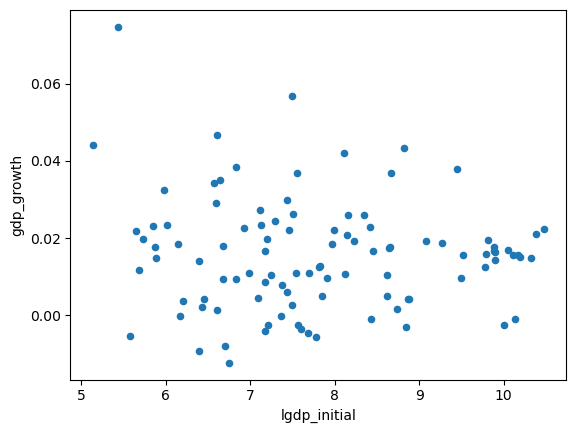

In [3]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

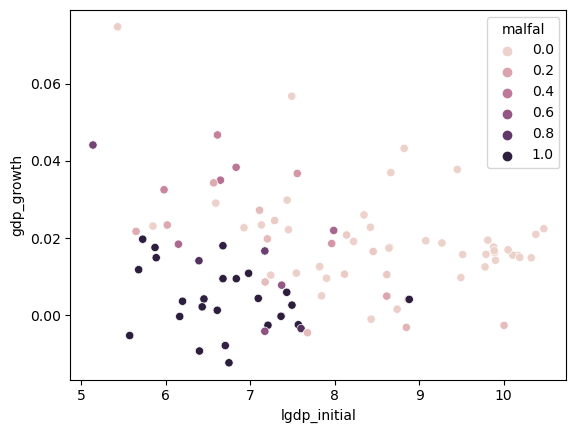

In [4]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [5]:
# all available variables
# 'demCGV', 'demBMR',
vv_institutions = ['marketref', 'dem', 'demreg']
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
#, 'pdivhmi', 'pdivhmi_aa'
# vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst']

vv_geneticdiversity = ['pdiv', 'pdiv_aa'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
# 'uvdamage'
vv_danger = ['yellow', 'malfal'] # Diseases
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 
vv_popgrowth = ['pop_growth']

#'historical': vv_historical,
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'popgrowth': vv_popgrowth,
        'education': vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

# Variables we use
# Institutions, geography, religion, danger (health), resources, education, pop growth



In [6]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [7]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [8]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [9]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


# Part 1: Redefine variables

In [10]:
controls = vv_all['geography'] + vv_all['institutions'] + vv_all['religion'] + vv_all['danger'] + vv_all['resources'] + vv_all['education']
controls_plus = controls + ['pop_growth', 'investment_rate']
vars = ['lgdp_initial'] + controls_plus
all_vars = ['gdp_growth'] + vars 

I = dat[all_vars].notnull().all(1)

# Make name for all_vars
Xnames = dat.loc[I, vars].columns
Znames = dat.loc[I, controls_plus].columns


## 1.2 Define variables y, X, d, Z

In [11]:
y = dat.loc[I,'gdp_growth'].values * 100. #easier to read output when growth is in 100%
d = dat.loc[I ,'lgdp_initial']
X = dat.loc[I, vars].values
Z_basic = dat.loc[I , controls_plus].values

Z_pol = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit_transform(Z_basic)

Z_pol_names = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False).fit(Z_basic).get_feature_names_out(Znames)

# we stack X_pol = (d, Z_pol) later

# Find N
N = X.shape[0]

print(y.shape)
print(d.shape)
print(X.shape)
print(Z_basic.shape)
print(Z_pol.shape)


assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

(71,)
(71,)
(71, 39)
(71, 38)
(71, 779)


## 1.3 Check for variables with 0 sigma

In [12]:
sd = X.std(0, ddof=1)
bad = np.unique(np.where(~np.isfinite((X - X.mean(0)) / sd))[1])
print("bad cols:", bad)

# For pols
sd = Z_pol.std(0, ddof=1)
bad = np.unique(np.where(~np.isfinite((Z_pol - Z_pol.mean(0)) / sd))[1])
print("bad cols:", bad)




bad cols: []
bad cols: [529 540 541 542 543 549 550 551 563 570 571 581 583 590 598]


C:\Users\lucas\AppData\Local\Temp\ipykernel_2712\1537233915.py:7: RuntimeWarning: invalid value encountered in divide
  bad = np.unique(np.where(~np.isfinite((Z_pol - Z_pol.mean(0)) / sd))[1])


## 1.3.2 Renames X_pol and Z_pol_basic after removing 0-variance variables

In [13]:
def drop_zero_variance(X, names, ddof=1, atol=1e-12):
    """
    Returns (X_kept, names_kept, removed_idx, removed_names)
    - Flags columns with std ~ 0 or non-finite std (NaN/Inf).
    """
    sd = X.std(axis=0, ddof=ddof)
    zero_mask = np.isclose(sd, 0, atol=atol) | ~np.isfinite(sd)

    removed_idx = np.where(zero_mask)[0]
    removed_names = [names[i] for i in removed_idx]

    X_kept = X[:, ~zero_mask]
    names_kept = [n for n, keep in zip(names, ~zero_mask) if keep]

    return X_kept, names_kept, removed_idx, removed_names

# --- For X ---
#X, Xnames, bad_idx_X, bad_names_X = drop_zero_variance(X, Xnames)
#print("Zero-variance cols in X (idx):", bad_idx_X)
#print("Zero-variance col names in X:", bad_names_X)

# --- For Z_pol ---
Z_pol, Z_pol_names, bad_idx_Xpol, bad_names_Xpol = drop_zero_variance(Z_pol, Z_pol_names)
print("Zero-variance cols in Z_pol (idx):", bad_idx_Xpol)
print("Zero-variance col names in Z_pol:", bad_names_Xpol)


Zero-variance cols in Z_pol (idx): [529 540 541 542 543 549 550 551 563 570 571 581 583 590 598]
Zero-variance col names in Z_pol: ['landlock oceania', 'landlock goldm', 'landlock iron', 'landlock silv', 'landlock zinc', 'africa asia', 'africa oceania', 'africa americas', 'africa silv', 'asia oceania', 'asia americas', 'asia goldm', 'asia silv', 'oceania americas', 'oceania malfal']


In [14]:
# Create X_pol
X_pol = np.column_stack((d, Z_pol))

# Create X_pol_names
X_pol_names = np.r_[['lgdp_initial'], Z_pol_names]

# Finds N
N_pol = X_pol.shape[0]

print(X_pol.shape)

print(X_pol_names)



(71, 765)
['lgdp_initial' 'tropicar' 'distr' 'distcr' 'distc' 'suitavg' 'temp'
 'suitgini' 'elevavg' 'elevstd' 'kgatr' 'precip' 'area' 'abslat' 'cenlong'
 'area_ar' 'rough' 'landlock' 'africa' 'asia' 'oceania' 'americas'
 'marketref' 'dem' 'demreg' 'pprotest' 'pcatholic' 'pmuslim' 'yellow'
 'malfal' 'oilres' 'goldm' 'iron' 'silv' 'zinc' 'ls_bl' 'lh_bl'
 'pop_growth' 'investment_rate' 'tropicar^2' 'tropicar distr'
 'tropicar distcr' 'tropicar distc' 'tropicar suitavg' 'tropicar temp'
 'tropicar suitgini' 'tropicar elevavg' 'tropicar elevstd'
 'tropicar kgatr' 'tropicar precip' 'tropicar area' 'tropicar abslat'
 'tropicar cenlong' 'tropicar area_ar' 'tropicar rough'
 'tropicar landlock' 'tropicar africa' 'tropicar asia' 'tropicar oceania'
 'tropicar americas' 'tropicar marketref' 'tropicar dem' 'tropicar demreg'
 'tropicar pprotest' 'tropicar pcatholic' 'tropicar pmuslim'
 'tropicar yellow' 'tropicar malfal' 'tropicar oilres' 'tropicar goldm'
 'tropicar iron' 'tropicar silv' 'tropicar zi

## 1.4 Standarization

In [15]:
# Create a function for standardizing
def standardize(X):

    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_tilde = standardize(X)
d_tilde = standardize(d)
Z_tilde = standardize(Z_basic)
Z_pol_tilde = standardize(Z_pol)
X_pol_tilde = standardize(X_pol)

# Drops those with nan values (0 variance)
X_pol_tilde = X_pol_tilde[~np.isnan(X_pol_tilde).any(axis=1)]


# Part 2: Defines BRT and BCCH

## 2.1 BRT

In [16]:
# Make a function that calculates BRT. Hint: You implemented a version of this last week
def BRT(X_tilde,y):
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c=1.1
    alpha=0.05

    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

## 2.2 BCCH

In [17]:
def BCCH(X_tilde, y):
    # BCCH pilot penalty
    n,p = X.shape
    c = 1.1
    alpha = 0.05
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
    print('Penalty_pilot: ', round(penalty_pilot, 2))

    # Pilot estimates
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

    # Alternative: Manually
    coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coeff_pilot)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
    print('Penalty BCCH: ', round(penalty_BCCH, 2))

    # Updated estimates
    fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
    coeff_BCCH = fit_BCCH.coef_
    print('Coefficients: ', np.round(coeff_BCCH))

    return penalty_BCCH



In [18]:
print("lambda_BRT =", BRT(X_tilde, y).round(2))
print("lambda_BCH =", BCCH(X_tilde, y).round(2))

lambda_BRT = 0.61
Penalty_pilot:  1.24
Penalty BCCH:  1.24
Coefficients:  [-0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0.]
lambda_BCH = 1.24


### 2.2.2 BRT penalty test which variables


In [19]:
n,p = X_tilde.shape
sigma = np.std(y)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((X_tilde**2),axis=0))**0.5 # Note: this equals 1 for standardized data, and is therefore not necessary to compute or include in the equation
print(max_term)
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p)) # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
selected_variables_BRT = (coeff_BRT!=0)
print('Selected variables: ', Xnames[selected_variables_BRT].to_list())

0.9929327736346241
Penalty_BRT:  0.6
Coefficients:  [-0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0.]
Selected variables:  ['asia']


In [20]:
n,p = Z_tilde.shape
sigma = np.std(d)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((Z_tilde**2),axis=0))**0.5 # Note: this equals 1 for standardized data, and is therefore not necessary to compute or include in the equation
print(max_term)
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p)) # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(Z_tilde,d)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
selected_variables_BRT = (coeff_BRT!=0)
print('Selected variables: ', Znames[selected_variables_BRT].to_list())

0.9929327736346241
Penalty_BRT:  0.59
Coefficients:  [-0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.]
Selected variables:  ['abslat', 'ls_bl', 'lh_bl']


### 2.2.3 BRT penalty level polynomials

In [21]:
n,p = X_pol_tilde.shape
sigma = np.std(y)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((X_pol_tilde**2),axis=0))**0.5 # Note: this equals 1 for standardized data, and is therefore not necessary to compute or include in the equation
print(max_term)
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p)) # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_pol_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
mask = np.asarray(coeff_BRT).ravel() != 0
names = pd.Series(X_pol_names)

print('Selected variables:', names[mask].to_list())  # note: .to_list() for Pandas Series


0.9929327736346253
Penalty_BRT:  0.75
Coefficients:  [-0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
  0. -0. -0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0.
  0.  0. -0. -0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0.  0

In [22]:
n,p = Z_pol_tilde.shape
sigma = np.std(d)
c = 1.1
alpha = 0.05
max_term = np.max((1/n) * np.sum((Z_pol_tilde**2),axis=0))**0.5 # Note: this equals 1 for standardized data, and is therefore not necessary to compute or include in the equation
print(max_term)
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p)) # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(Z_pol_tilde,d)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
mask = np.asarray(coeff_BRT).ravel() != 0
names = pd.Series(Z_pol_names)

print('Selected variables:', names[mask].to_list())  # note: .to_list() for Pandas Series


0.9929327736346244
Penalty_BRT:  0.73
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.
  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0.  0

### No need to test BCCH as shown earlier the penalty level is too high for any variables

# Part 3: Post Double Lasso without and with poly

## 3.1 BRT

In [23]:
# Calculate BRT
penalty_BRT_yx = BRT(X_tilde,y)
print("lambda_BRT =",penalty_BRT_yx.round(2))

# Calculate BRT poly
penalty_BRT_yx_pol = BRT(X_pol_tilde,y)
print("lambda_BRT_pol =",penalty_BRT_yx_pol.round(2))



lambda_BRT = 0.61
lambda_BRT_pol = 0.75


In [24]:
# Run Lasso 
fit_BRT_yx = Lasso(penalty_BRT_yx, max_iter=10000).fit(X_tilde, y)
fit_BRT_yx_pol = Lasso(penalty_BRT_yx_pol, max_iter=10000).fit(X_pol_tilde, y)

coefs = fit_BRT_yx.coef_
coefs_pol = fit_BRT_yx_pol.coef_


# Calculate residuals
resyx = y - fit_BRT_yx.predict(X_tilde)
resyx_pol = y - fit_BRT_yx_pol.predict(X_pol_tilde)


# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + d_tilde*coefs[0]
resyxz_pol = resyx_pol + d_tilde*coefs_pol[0]

# Display first coefficient
print("First coefficient =",coefs[0].round(5))
print("First coefficient (poly) =",coefs_pol[0].round(5))


First coefficient = -0.0
First coefficient (poly) = -0.0


Step two, lasso Z on d

In [25]:
# Calculate BRT without pol
penalty_BRT_dz = BRT(Z_tilde, d)
penalty_BRT_dz_pol = BRT(Z_pol_tilde, d)


print("lambda_BRT =",penalty_BRT_dz.round(2))
print("lambda_BRT =",penalty_BRT_dz_pol.round(2))

#calculate BRT with pol


lambda_BRT = 0.59
lambda_BRT = 0.73


In [26]:
# Run Lasso
fit_BRT_dz = Lasso(penalty_BRT_dz, max_iter=10000).fit(Z_tilde, d)
fit_BRT_dz_pol = Lasso(penalty_BRT_dz_pol, max_iter=10000).fit(Z_pol_tilde, d)


coefs = fit_BRT_dz.coef_
coefs_pol = fit_BRT_dz_pol.coef_

# Calculate residuals
resdz = d - fit_BRT_dz.predict(Z_tilde)
resdz_pol = d - fit_BRT_dz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =", coefs[0].round(2))
print("First coefficient (poly) =", coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [27]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@d
BRT_alpha_PDL = num/denom

# Display alpha
print("BRT_alpha_PDL = ",BRT_alpha_PDL.round(2))

# Calculate alpha for pol
num = resdz_pol@resyxz_pol
denom = resdz_pol@d
BRT_alpha_PDL_pol = num/denom

# Display alpha
print("BRT_alpha_PDL_pol = ",BRT_alpha_PDL_pol.round(2))

BRT_alpha_PDL =  -0.25
BRT_alpha_PDL_pol =  -0.2


In [28]:
print(resdz)
print(resyxz)

# for pol
print(resdz_pol)
print(resyxz_pol)

4      0.756550
7      1.613597
8      1.359593
11     1.373849
12    -0.884212
         ...   
175    0.539872
176    1.211308
185    0.570117
187   -0.278270
188   -0.600730
Name: lgdp_initial, Length: 71, dtype: float64
4     -1.117614
7      0.020364
8      0.240024
11     0.097968
12    -0.581206
         ...   
175    0.211754
176    0.166215
185   -1.372279
187   -1.556367
188   -1.945090
Name: lgdp_initial, Length: 71, dtype: float64
4      0.902729
7      1.979753
8      1.436545
11     1.406071
12    -1.040354
         ...   
175    0.564715
176    1.392646
185    0.821836
187   -0.385142
188   -0.563871
Name: lgdp_initial, Length: 71, dtype: float64
4     -1.123478
7      0.014500
8      0.234160
11     0.092104
12    -0.587070
         ...   
175    0.205890
176    0.160351
185   -1.378143
187   -1.562231
188   -1.950954
Name: lgdp_initial, Length: 71, dtype: float64


In [29]:
# Calculate variance    
num = resdz**2@resyx**2/N
denom = (resdz.T@resdz/N)**2
BRT_sigma2_PDL = num/denom

# Display variance
print("BRT_sigma2_PDL = ",BRT_sigma2_PDL.round(2))

# for pol
# Calculate variance    
num = resdz_pol**2@resyx_pol**2/N_pol
denom = (resdz_pol.T@resdz_pol/N_pol)**2
BRT_sigma2_PDL_pol = num/denom

# Display variance
print("BRT_sigma2_PDL_pol = ",BRT_sigma2_PDL_pol.round(2))

BRT_sigma2_PDL =  2.9
BRT_sigma2_PDL_pol =  2.22


In [30]:
# Calculate standard error
BRT_se_PDL = np.sqrt(BRT_sigma2_PDL/N)
BRT_se_PDL_pol = np.sqrt(BRT_sigma2_PDL_pol/N_pol)

# Display standard error
print("BRT_se_PDL = ",BRT_se_PDL.round(2))
print("BRT_se_PDL_pol = ",BRT_se_PDL_pol.round(2))

BRT_se_PDL =  0.2
BRT_se_PDL_pol =  0.18


Calculate confidence interval

In [31]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
BRT_CI_low_PDL  = BRT_alpha_PDL - q * BRT_se_PDL
BRT_CI_high_PDL = BRT_alpha_PDL + q * BRT_se_PDL

BRT_CI_low_PDL_pol  = BRT_alpha_PDL_pol - q * BRT_se_PDL_pol
BRT_CI_high_PDL_pol = BRT_alpha_PDL_pol + q * BRT_se_PDL_pol

# Display confidence interval
print("CI_PDL = ",(BRT_CI_low_PDL.round(2),BRT_CI_high_PDL.round(2)))
print("CI_PDL_pol = ",(BRT_CI_low_PDL_pol.round(2),BRT_CI_high_PDL_pol.round(2)))

CI_PDL =  (-0.65, 0.14)
CI_PDL_pol =  (-0.55, 0.15)


## Part 3.2 PDL with BCCH

In [32]:
# Calculate BCCH
penalty_BCCH_yx = BCCH(X_tilde,y)
penalty_BCCH_yx_pol = BCCH(X_pol_tilde,y)

print("lambda_BCCH =",penalty_BCCH_yx.round(2))
print("lambda_BCCH_pol =",penalty_BCCH_yx_pol.round(2))


Penalty_pilot:  1.24
Penalty BCCH:  1.24
Coefficients:  [-0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0.]
Penalty_pilot:  2.22
Penalty BCCH:  2.22
Coefficients:  [-0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
  0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.
  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0

In [33]:
# Run Lasso 
fit_BCCH_yx = Lasso(penalty_BCCH_yx, max_iter=10000).fit(X_tilde, y)
fit_BCCH_yx_pol = Lasso(penalty_BCCH_yx_pol, max_iter=10000).fit(X_pol_tilde, y)

# Coef for and without pol
coefs=fit_BCCH_yx.coef_
coefs_pol=fit_BCCH_yx_pol.coef_


# Calculate residuals
BCCH_resyx = y-fit_BCCH_yx.predict(X_tilde)
BCCH_resyx_pol = y - fit_BCCH_yx_pol.predict(X_pol_tilde)


# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
BCCH_resyxz = BCCH_resyx + d_tilde*coefs[0]
BCCH_resyxz_pol = BCCH_resyx_pol + d_tilde*coefs_pol[0]


# Display first coefficient
print("First coefficient =",coefs[0].round(5))
print("First coefficient (poly) =",coefs_pol[0].round(5))


First coefficient = -0.0
First coefficient (poly) = -0.0


In [34]:
# Calculate BCCH
penalty_BCCH_dz = BCCH(Z_tilde, d)
penalty_BCCH_dz_pol = BCCH(Z_pol_tilde, d)

print("lambda_BCCH =",penalty_BCCH_dz.round(2))
print("lambda_BCCH_pol =",penalty_BCCH_dz_pol.round(2))



Penalty_pilot:  0.93
Penalty BCCH:  0.93
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.]
Penalty_pilot:  1.02
Penalty BCCH:  1.02
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
  

In [35]:
# Run Lasso
fit_BCCH_dz = Lasso(penalty_BCCH_dz, max_iter=10000).fit(Z_tilde, d)
fit_BCCH_dz_pol = Lasso(penalty_BCCH_dz_pol, max_iter=10000).fit(Z_pol_tilde, d)

coefs=fit_BCCH_dz.coef_
coefs_pol=fit_BCCH_dz_pol.coef_

# Calculate residuals
BCCH_resdz=d-fit_BCCH_dz.predict(Z_tilde)
BCCH_resdz_pol=d-fit_BCCH_dz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =",coefs[0].round(2))
print("First coefficient (poly) =",coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [36]:
# Calculate alpha
num = BCCH_resdz@BCCH_resyxz
num_pol = BCCH_resdz_pol@BCCH_resyxz_pol

denom = BCCH_resdz@d
denom_pol = BCCH_resdz_pol@d

BCCH_alpha_PDL = num/denom
BCCH_alpha_PDL_pol = num_pol/denom_pol

# Display alpha
print("BCCH_alpha_PDL = ",BCCH_alpha_PDL.round(2))
print("BCCH_alpha_PDL (poly) = ",BCCH_alpha_PDL_pol.round(2))

BCCH_alpha_PDL =  -0.17
BCCH_alpha_PDL (poly) =  -0.17


In [37]:
print(BCCH_resdz)
print(BCCH_resyxz)

print(BCCH_resdz_pol)
print(BCCH_resyxz_pol)

4      0.933128
7      2.238500
8      1.948488
11     1.960109
12    -1.252166
         ...   
175    0.710635
176    2.119436
185    0.807263
187   -0.565401
188   -0.757401
Name: lgdp_initial, Length: 71, dtype: float64
4     -1.177604
7     -0.039626
8      0.180034
11     0.037978
12    -0.641196
         ...   
175    0.151764
176    0.106226
185   -1.432269
187   -1.616357
188   -2.005080
Name: lgdp_initial, Length: 71, dtype: float64
4      0.933814
7      2.238675
8      1.950145
11     1.962022
12    -1.253267
         ...   
175    0.711248
176    2.120413
185    0.807584
187   -0.566101
188   -0.757736
Name: lgdp_initial, Length: 71, dtype: float64
4     -1.177604
7     -0.039626
8      0.180034
11     0.037978
12    -0.641196
         ...   
175    0.151764
176    0.106226
185   -1.432269
187   -1.616357
188   -2.005080
Name: lgdp_initial, Length: 71, dtype: float64


In [38]:
# Calculate variance    
num = BCCH_resdz**2@BCCH_resyx**2/N
num_pol = BCCH_resdz_pol**2@BCCH_resyx**2/N_pol

denom = (BCCH_resdz.T@BCCH_resdz/N)**2
denom_pol = (BCCH_resdz_pol.T@BCCH_resdz_pol/N_pol)**2

BCCH_sigma2_PDL = num/denom
BCCH_sigma2_PDL_pol = num_pol/denom_pol

# Display variance
print("BCCH_sigma2_PDL = ",BCCH_sigma2_PDL.round(2))
print("BCCH_sigma2_PDL (poly) = ",BCCH_sigma2_PDL_pol.round(2))

BCCH_sigma2_PDL =  1.48
BCCH_sigma2_PDL (poly) =  1.48


In [39]:
# Calculate standard error
BCCH_se_PDL = np.sqrt(BCCH_sigma2_PDL/N)
BCCH_se_PDL_pol = np.sqrt(BCCH_sigma2_PDL_pol/N_pol)

# Display standard error
print("BCCH_se_PDL = ",BCCH_se_PDL.round(2))
print("BCCH_se_PDL (poly) = ",BCCH_se_PDL_pol.round(2))

BCCH_se_PDL =  0.14
BCCH_se_PDL (poly) =  0.14


In [40]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
BCCH_CI_low_PDL  = BCCH_alpha_PDL - q * BCCH_se_PDL
BCCH_CI_high_PDL = BCCH_alpha_PDL + q * BCCH_se_PDL

BCCH_CI_low_PDL_pol  = BCCH_alpha_PDL_pol - q * BCCH_se_PDL_pol
BCCH_CI_high_PDL_pol = BCCH_alpha_PDL_pol + q * BCCH_se_PDL_pol

# Display confidence interval
print("BCCH_CI_PDL = ",(BCCH_CI_low_PDL.round(2),BCCH_CI_high_PDL.round(2)))
print("BCCH_CI_PDL (poly) = ",(BCCH_CI_low_PDL_pol.round(2),BCCH_CI_high_PDL_pol.round(2)))

BCCH_CI_PDL =  (-0.46, 0.11)
BCCH_CI_PDL (poly) =  (-0.45, 0.11)


# Part 4: Post Partial-Out Lasso

## 4.1 BRT PPOL

In [41]:
penalty_BRT_yz = BRT(Z_tilde, y)
penalty_BRT_yz_pol = BRT(Z_pol_tilde, y)

print("lambda_BRT =",penalty_BRT_yz.round(2))
print("lambda_BRT (poly) =",penalty_BRT_yz_pol.round(2))

lambda_BRT = 0.61
lambda_BRT (poly) = 0.75


In [42]:
# Run Lasso
fit_BRT_yz = Lasso(penalty_BRT_yz, max_iter=10000).fit(Z_tilde,y)
fit_BRT_yz_pol = Lasso(penalty_BRT_yz_pol, max_iter=10000).fit(Z_pol_tilde,y)

coefs=fit_BRT_yz.coef_
coefs_pol=fit_BRT_yz_pol.coef_


# Calculate residuals
resyz = y - fit_BRT_yz.predict(Z_tilde)
resyz_pol = y - fit_BRT_yz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =",coefs[0].round(2))
print("First coefficient (poly) =",coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [43]:
penalty_BRT_dz = BRT(Z_tilde, d)
penalty_BRT_dz_pol = BRT(Z_pol_tilde, d)

print("lambda_BRT =",penalty_BRT_dz.round(2))
print("lambda_BRT (poly) =",penalty_BRT_dz_pol.round(2))

lambda_BRT = 0.59
lambda_BRT (poly) = 0.73


In [44]:
# Run Lasso
fit_BRT_dz = Lasso(penalty_BRT_dz, max_iter=10000).fit(Z_tilde,d)
fit_BRT_dz_pol = Lasso(penalty_BRT_dz_pol, max_iter=10000).fit(Z_pol_tilde,d)

coefs=fit_BRT_dz.coef_
coefs_pol=fit_BRT_dz_pol.coef_

# Calculate residuals
resdz = d - fit_BRT_dz.predict(Z_tilde)
resdz_pol = d - fit_BRT_dz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =",coefs[0].round(2))
print("First coefficient (poly) =",coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [45]:
# Calculate alpha
num = resdz.T@resyz
num_pol = resdz_pol.T@resyz_pol

denom = resdz.T@resdz
denom_pol = resdz_pol.T@resdz_pol

BRT_alpha_PPOL = num/denom
BRT_alpha_PPOL_pol = num_pol/denom_pol

# Display alpha
print("alpha_PPOL = ",BRT_alpha_PPOL.round(2))
print("alpha_PPOL (poly) = ",BRT_alpha_PPOL_pol.round(2))

alpha_PPOL =  -0.3
alpha_PPOL (poly) =  -0.23


The variance of the PPOL estimator is given by

$$
\breve{\sigma}^2 = \frac{N^{-1}\sum_i \hat{\zeta}_i^2 \hat{\nu}_i^2}{(N^{-1}\sum_i \hat{\nu}_i^2)^2}
$$

where it can be shown that 
$$
\sqrt{N} (\breve{\alpha} - \alpha_0)/\breve{\sigma} \xrightarrow{d} N(0,1)
$$

Calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\breve{\alpha}$.

In [46]:
# Calculate variance    
num = resyz**2 @ resdz**2 / N
num_pol = resyz_pol**2 @ resdz_pol**2 / N_pol

denom = (resdz.T@resdz / N)**2
denom_pol = (resdz_pol.T@resdz_pol / N_pol)**2

BRT_sigma2_PPOL = num/denom
BRT_sigma2_PPOL_pol = num_pol/denom_pol

# Display variance
print("BRT_sigma2_PPOL = ",BRT_sigma2_PPOL.round(2))
print("BRT_sigma2_PPOL (poly) = ",BRT_sigma2_PPOL_pol.round(2))

BRT_sigma2_PPOL =  2.9
BRT_sigma2_PPOL (poly) =  2.22


In [47]:
# Calculate standard error
BRT_se_PPOL = np.sqrt(BRT_sigma2_PPOL/N)
BRT_se_PPOL_pol = np.sqrt(BRT_sigma2_PPOL_pol/N_pol)

# Display standard error
print("BRT_se_PPOL = ",BRT_se_PPOL.round(2))
print("BRT_se_PPOL (poly) = ",BRT_se_PPOL_pol.round(2))

BRT_se_PPOL =  0.2
BRT_se_PPOL (poly) =  0.18


In [48]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
BRT_CI_low_PPOL  = BRT_alpha_PPOL - q * BRT_se_PPOL
BRT_CI_high_PPOL = BRT_alpha_PPOL + q * BRT_se_PPOL

# For pol
BRT_CI_low_PPOL_pol  = BRT_alpha_PPOL_pol - q * BRT_se_PPOL_pol
BRT_CI_high_PPOL_pol = BRT_alpha_PPOL_pol + q * BRT_se_PPOL_pol

# Display confidence interval
print("BRT_CI_PDL = ",(BRT_CI_low_PPOL.round(2),BRT_CI_high_PPOL.round(2)))
print("BRT_CI_PDL (poly) = ",(BRT_CI_low_PPOL_pol.round(2),BRT_CI_high_PPOL_pol.round(2)))

BRT_CI_PDL =  (-0.7, 0.09)
BRT_CI_PDL (poly) =  (-0.58, 0.11)


## 4.2 PPOL BCCH

In [49]:
penalty_BCCH_yz = BCCH(Z_tilde, y)
penalty_BCCH_yz_pol = BCCH(Z_pol_tilde, y)


print("lambda_BRT =",penalty_BCCH_yz.round(2))
print("lambda_BRT (poly) =",penalty_BCCH_yz_pol.round(2))

Penalty_pilot:  1.24
Penalty BCCH:  1.24
Coefficients:  [-0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.
  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.
 -0.  0.]
Penalty_pilot:  2.22
Penalty BCCH:  2.22
Coefficients:  [-0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.
  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.
  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
  0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.
 -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.
  

In [50]:
# Run Lasso
fit_BCCH_yz = Lasso(penalty_BCCH_yz, max_iter=10000).fit(Z_tilde,y)
fit_BCCH_yz_pol = Lasso(penalty_BCCH_yz_pol, max_iter=10000).fit(Z_pol_tilde,y)

coefs = fit_BCCH_yz.coef_
coefs_pol = fit_BCCH_yz_pol.coef_

# Calculate residuals
BCCH_res_yz = y - fit_BCCH_yz.predict(Z_tilde)
BCCH_res_yz_pol = y - fit_BCCH_yz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =",coefs[0].round(2))
print("First coefficient (poly) =",coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [51]:
penalty_BCCH_dz = BCCH(Z_tilde, d)
penalty_BCCH_dz_pol = BCCH(Z_pol_tilde, d)

print("lambda_BCCH =",penalty_BCCH_dz.round(2))
print("lambda_BCCH (poly) =",penalty_BCCH_dz_pol.round(2))

Penalty_pilot:  0.93
Penalty BCCH:  0.93
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.]
Penalty_pilot:  1.02
Penalty BCCH:  1.02
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
 -0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0.
  

In [52]:
# Run Lasso
fit_BCCH_dz = Lasso(penalty_BCCH_dz, max_iter=10000).fit(Z_tilde,d)
fit_BCCH_dz_pol = Lasso(penalty_BCCH_dz_pol, max_iter=10000).fit(Z_pol_tilde,d)

coefs = fit_BCCH_dz.coef_
coefs_pol = fit_BCCH_dz_pol.coef_

# Calculate residuals
BCCH_res_dz = d - fit_BCCH_dz.predict(Z_tilde)
BCCH_res_dz_pol = d - fit_BCCH_dz_pol.predict(Z_pol_tilde)

# Display first coefficient
print("First coefficient =",coefs[0].round(2))
print("First coefficient (poly) =",coefs_pol[0].round(2))

First coefficient = -0.0
First coefficient (poly) = -0.0


In [53]:
# Calculate alpha
num = BCCH_res_dz.T@BCCH_res_yz
num_pol = BCCH_res_dz_pol.T@BCCH_res_yz_pol

denom = BCCH_res_dz.T@BCCH_res_dz
denom_pol = BCCH_res_dz_pol.T@BCCH_res_dz_pol


BCCH_alpha_PPOL = num/denom
BCCH_alpha_PPOL_pol = num_pol/denom_pol

# Display alpha
print("BCCH_alpha_PPOL = ",BCCH_alpha_PPOL.round(2))
print("BCCH_alpha_PPOL (poly) = ",BCCH_alpha_PPOL_pol.round(2))

BCCH_alpha_PPOL =  -0.17
BCCH_alpha_PPOL (poly) =  -0.17


#### Calculate variance

In [54]:
# Calculate variance    
num = BCCH_res_yz**2 @ BCCH_res_dz**2 / N
num_pol = BCCH_res_yz_pol**2 @ BCCH_res_dz_pol**2 / N_pol

denom = (BCCH_res_dz.T@BCCH_res_dz / N)**2
denom_pol = (BCCH_res_dz_pol.T@BCCH_res_dz_pol / N_pol)**2

BCCH_sigma2_PPOL = num/denom
BCCH_sigma2_PPOL_pol = num_pol/denom_pol

# Display variance
print("BCCH_sigma2_PPOL = ",BCCH_sigma2_PPOL.round(2))
print("BCCH_sigma2_PPOL (poly) = ",BCCH_sigma2_PPOL_pol.round(2))

BCCH_sigma2_PPOL =  1.48
BCCH_sigma2_PPOL (poly) =  1.48


In [55]:
# Calculate standard error
BCCH_se_PPOL = np.sqrt(BCCH_sigma2_PPOL/N)
BCCH_se_PPOL_pol = np.sqrt(BCCH_sigma2_PPOL_pol/N_pol)

# Display standard error
print("BCCH_se_PPOL = ",BCCH_se_PPOL.round(2))
print("BCCH_se_PPOL (poly) = ",BCCH_se_PPOL_pol.round(2))

BCCH_se_PPOL =  0.14
BCCH_se_PPOL (poly) =  0.14


In [56]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
BCCH_CI_low_PPOL  = BCCH_alpha_PPOL - q * BCCH_se_PPOL
BCCH_CI_high_PPOL = BCCH_alpha_PPOL + q * BCCH_se_PPOL

BCCH_CI_low_PPOL_pol  = BCCH_alpha_PPOL_pol - q * BCCH_se_PPOL_pol
BCCH_CI_high_PPOL_pol = BCCH_alpha_PPOL_pol + q * BCCH_se_PPOL_pol

# Display confidence interval
print("CI_PPOL = ",(BCCH_CI_low_PPOL.round(2),BCCH_CI_high_PPOL.round(2)))
print("CI_PPOL (poly) = ",(BCCH_CI_low_PPOL_pol.round(2),BCCH_CI_high_PPOL_pol.round(2)))

CI_PPOL =  (-0.46, 0.11)
CI_PPOL (poly) =  (-0.45, 0.11)


# Part 5: Estimation table(s)

## 5.1 Table 1: No polynomials

In [57]:
Estimator = (['PDL', 'PDL', 'PPOL', 'PPOL'])

Penalty = (['BRT', 'BCCH', 'BRT', 'BCCH'])

Coefficients = ([BRT_alpha_PDL.round(2), BCCH_alpha_PDL.round(2), BRT_alpha_PPOL.round(2), BCCH_alpha_PPOL.round(2)])

Standard_deviation = ([BRT_se_PDL.round(2), BCCH_se_PDL.round(2), BRT_se_PPOL.round(2), BCCH_se_PPOL.round(2)])

CI_low = ([BRT_CI_low_PDL.round(2), BCCH_CI_low_PDL.round(2), BRT_CI_low_PPOL.round(2), BCCH_CI_low_PPOL.round(2)])
CI_high = ([BRT_CI_high_PDL.round(2), BCCH_CI_high_PDL.round(2), BRT_CI_high_PPOL.round(2), BCCH_CI_high_PPOL.round(2)])

Controls  = Z_tilde.shape[1]
Countries = Z_tilde.shape[0] 


results = pd.DataFrame({
    'Estimator': Estimator,
    'Penalty': Penalty,
    'Log GDP pr capita 1970': Coefficients,
    'SD': Standard_deviation,
    '95 pct. CI low': CI_low,
    '95 pct. CI high': CI_high, 
    'Controls': Controls,
    'Countries': Countries 
})  


## 5.2 To latex

In [58]:
print(results.set_index(['Estimator','Penalty']).T.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrr}
\toprule
Estimator & \multicolumn{2}{r}{PDL} & \multicolumn{2}{r}{PPOL} \\
Penalty & BRT & BCCH & BRT & BCCH \\
\midrule
Log GDP pr capita 1970 & -0.25 & -0.17 & -0.30 & -0.17 \\
SD & 0.20 & 0.14 & 0.20 & 0.14 \\
95 pct. CI low & -0.65 & -0.46 & -0.70 & -0.46 \\
95 pct. CI high & 0.14 & 0.11 & 0.09 & 0.11 \\
Controls & 38.00 & 38.00 & 38.00 & 38.00 \\
Countries & 71.00 & 71.00 & 71.00 & 71.00 \\
\bottomrule
\end{tabular}



## 5.3 Table 2: Polynomials

In [59]:
Estimator_pol = (['PDL', 'PDL', 'PPOL', 'PPOL'])

Penalty_pol = (['BRT', 'BCCH', 'BRT', 'BCCH'])

Coefficients_pol = ([BRT_alpha_PDL_pol.round(2), BCCH_alpha_PDL_pol.round(2), BRT_alpha_PPOL_pol.round(2), BCCH_alpha_PPOL_pol.round(2)])

Standard_deviation_pol = ([BRT_se_PDL_pol.round(2), BCCH_se_PDL_pol.round(2), BRT_se_PPOL_pol.round(2), BCCH_se_PPOL_pol.round(2)])

CI_low_pol = ([BRT_CI_low_PDL_pol.round(2), BCCH_CI_low_PDL_pol.round(2), BRT_CI_low_PPOL_pol.round(2), BCCH_CI_low_PPOL_pol.round(2)])
CI_high_pol = ([BRT_CI_high_PDL_pol.round(2), BCCH_CI_high_PDL_pol.round(2), BRT_CI_high_PPOL_pol.round(2), BCCH_CI_high_PPOL_pol.round(2)])

Controls_pol  = Z_pol_tilde.shape[1]
Countries_pol = Z_tilde.shape[0] 


results_pol = pd.DataFrame({
    'Estimator': Estimator_pol,
    'Penalty': Penalty_pol,
    'Log GDP pr capita 1970': Coefficients_pol,
    'SD': Standard_deviation_pol,
    '95 pct. CI low': CI_low_pol,
    '95 pct. CI high': CI_high_pol, 
    'Controls': Controls_pol,
    'Countries': Countries_pol
})  


In [60]:
print(results_pol.set_index(['Estimator','Penalty']).T.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrr}
\toprule
Estimator & \multicolumn{2}{r}{PDL} & \multicolumn{2}{r}{PPOL} \\
Penalty & BRT & BCCH & BRT & BCCH \\
\midrule
Log GDP pr capita 1970 & -0.20 & -0.17 & -0.23 & -0.17 \\
SD & 0.18 & 0.14 & 0.18 & 0.14 \\
95 pct. CI low & -0.55 & -0.45 & -0.58 & -0.45 \\
95 pct. CI high & 0.15 & 0.11 & 0.11 & 0.11 \\
Controls & 764.00 & 764.00 & 764.00 & 764.00 \\
Countries & 71.00 & 71.00 & 71.00 & 71.00 \\
\bottomrule
\end{tabular}



# Part 6. Graphs

## 6.1 Penalty grids

In [61]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.001, 80000, num = 50)

coefs=[]
for lamb in penalty_grid:
    fit = Lasso(alpha = lamb).fit(X_tilde,y) 
    coefs.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

## 6.1.2 Penalty grid for polynomials

In [62]:
penalty_grid_pol = np.geomspace(0.001, 80000, num = 50)

coefs_pol=[]
for lamb_pol in penalty_grid_pol:
    fit = Lasso(alpha = lamb_pol).fit(X_pol_tilde,y) 
    coefs_pol.append(fit.coef_) # Note how we extract the coefficients from fit and append them to coefs

c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e-01, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e-01, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, toleranc

## 6.2 Creates the graph


In [63]:
def plot_lasso_path(penalty_grid, coefs, legends=None, vlines: dict = None,
                    y_label_pos=0.98, offset_pts=6, alternate_sides=True):
    plt.figure(figsize=(8, 5))
    coefs_array = np.asarray(coefs)
    if coefs_array.ndim == 1:
        coefs_array = coefs_array.reshape(-1, 1)

    ax = plt.gca()
    for j in range(coefs_array.shape[1]):
        ax.plot(penalty_grid, coefs_array[:, j], linewidth=1)

    ax.set_xscale('log')
    xmin, xmax = float(np.min(penalty_grid)), 1e1
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_xlabel(r"Penalty, $\lambda$")
    ax.set_ylabel(r"Estimates, $\widehat{\beta}_j(\lambda)$")

    if vlines:
        for i, (name, penalty) in enumerate(sorted(vlines.items(), key=lambda kv: kv[1])):
            p = float(penalty)
            if not (xmin <= p <= xmax):
                continue
            ax.axvline(p, linestyle='--', color='grey', alpha=0.6, zorder=0)

            # choose +offset (right) or -offset (left)
            sign = (-1 if (alternate_sides and i % 2 == 0) else 1)
            dx = sign * offset_pts

            ax.annotate(
                name,
                xy=(p, y_label_pos), xycoords=('data', 'axes fraction'),
                xytext=(dx, 0), textcoords='offset points',
                rotation=90, va='top', ha='center',
                annotation_clip=True, zorder=5
            )

    plt.tight_layout()
    plt.show()
    plt.close()


## 6.3 Estimates CV

In [64]:
# Estimate the model using LassoCV
fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X_tilde,y)
fit_CV_pol = LassoCV(cv=5, alphas=penalty_grid_pol).fit(X_pol_tilde,y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_ 
penalty_CV_pol = fit_CV_pol.alpha_

print('Penalty_CV: ', round(penalty_CV,4))
print('Penalty_CV_pol: ', round(penalty_CV_pol,4))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
coeff_CV_pol = fit_CV_pol.coef_
print('Coefficients: ', np.round(coeff_CV, 2))
print('Coefficients (Polynomial): ', np.round(coeff_CV_pol, 2))

# Investigate the selected variables
selected_mask = np.asarray(coeff_CV).ravel() != 0
selected_names = [name for name, keep in zip(Xnames, selected_mask) if keep]
print("Selected variables:", selected_names)



c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01646141209650054, tolerance: 0.011961784628947848
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02328967245710878, tolerance: 0.011961784628947848
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-02, tolerance: 1.377e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\anaconda3\Lib\site-

Penalty_CV:  0.0093
Penalty_CV_pol:  0.125
Coefficients:  [-1.38  0.06 -0.18  0.   -0.07 -0.06 -1.33 -0.05 -0.75 -0.    0.    0.
  0.18 -0.48  0.63 -0.    0.13  0.   -0.16 -0.   -0.    0.21 -0.15  0.34
 -0.28 -0.17  0.18 -0.    0.05 -0.41  0.16  0.   -0.    0.1   0.    0.1
 -0.   -0.19  0.4 ]
Coefficients (Polynomial):  [-0.16 -0.   -0.   -0.   -0.    0.   -0.   -0.   -0.    0.   -0.    0.
  0.    0.    0.    0.    0.   -0.   -0.    0.   -0.   -0.   -0.    0.
  0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.   -0.    0.    0.
 -0.   -0.    0.1  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.    0.    0.    0.   -0.   -0.    0.   -0.   -0.
 -0.    0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.   -0.
 -0.    0.   -0.01 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
  0.   -0.   -0.   -0.   -0.    0.    0.   -0.   -0.    0.   -0.   -0.
 -0.   -0.    0.    0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.
 -0.   -0.    0.   -0.   -0.   -0.   -0

c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e-02, tolerance: 1.196e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e-02, tolerance: 1.196e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-02, toleranc

## 6.4 Plotes lasso without polynomials

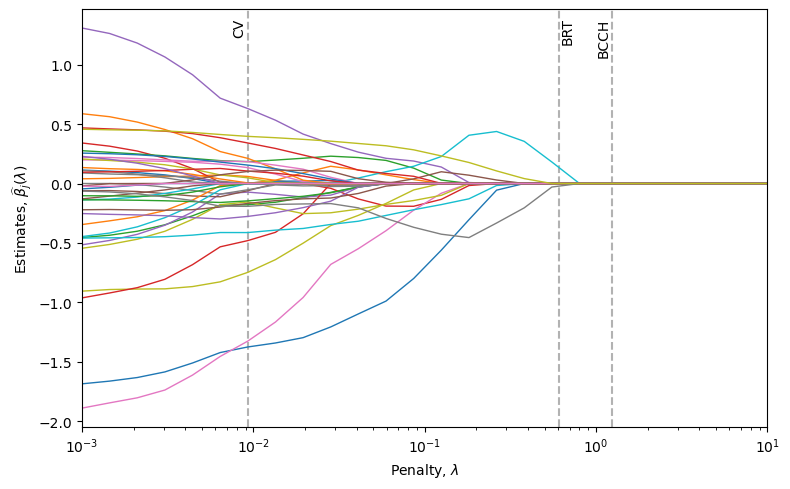

In [65]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames, vlines={'CV':penalty_CV, 'BRT':penalty_BRT_yx, 'BCCH':penalty_BCCH_yx})

## 6.5 Plot polynomials

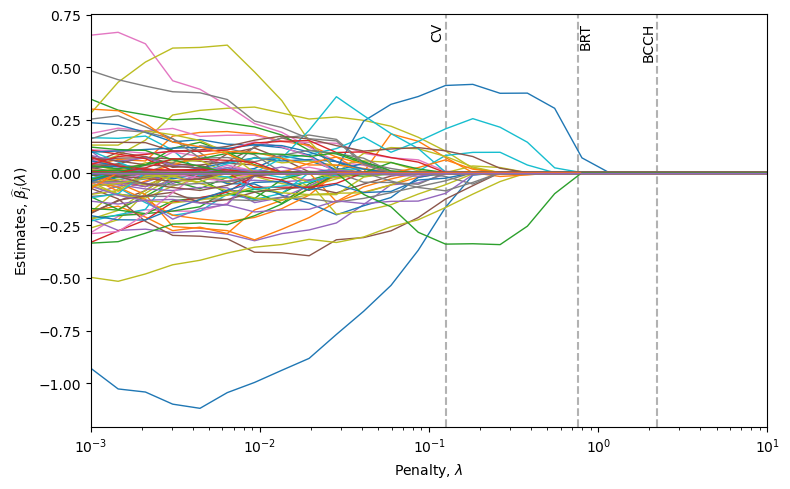

In [66]:
# Plot lasso path
plot_lasso_path(penalty_grid_pol, coefs_pol, X_pol_names, vlines={'CV':penalty_CV_pol, 'BRT':penalty_BRT_yx_pol, 'BCCH':penalty_BCCH_yx_pol})